***CIMS SIMULATION***

It's important to test the logic and method of the code before we actually try and put any actual data through it. I was also advised by John Magnotti that I should plot potential outcomes using the different decision rules using fixed parameters and test / simulated data to see how responses changed.

I've used the mean parameters from Magnotti et al., (2013) and 10,000 simulations to estimate the different response distributions related to each computational strategy.

In [129]:
import numpy as np
from numpy import random
import scipy
from scipy.stats import norm, binom
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving raw_df2.csv to raw_df2.csv


In [136]:
# EXPERIMENTAL PARAMETERS
async_conditions = [-300, -267, -200, -133, -100, -67, 0, 67, 100, 133, 200, 267, 300, 400, 500]
n_trials = 15000 
trials_per_cond = int(n_trials / len(async_conditions)) - 1 # -1 accounting for the way python includes zero

# PARAMS - FITTING WITH REASONABLE PARAMETERS FROM LAST EXPERIMENT
pc1 = 0.58
sens_noise = 100.0
mu1 = 0.0
sigma1 = 65.0
mu2 = -48.0
sigma2 = 126.0

# PARAM LISTS
exp_params = [async_conditions, n_trials, trials_per_cond]
model_params = [pc1, sens_noise, mu1, sigma1, mu2, sigma2]

# CIMS SIMULATION
def calc_posterior(cond, model_params):

  cond = float(cond) # make sure the condition is a float
  var1 = sigma1**2 # transform into variance for the cdf function
  var2 = sigma2**2
  varx = sens_noise**2
	
  lprior = 2 * np.log(pc1 / (1-pc1))
  b = np.log((varx + var2) / (varx + var1)) +  (mu2**2 / (var2 - var1))
  c = (1 / (varx + var1)) - (1 / (varx + var2))

  if lprior < -b:
    lprior = -b

  bound = np.sqrt((lprior+b)/c)
  middle = abs(mu2) * (varx+var1)/(var2-var1)
  upper = middle + bound
  lower = middle - bound

  rng = rng = np.random.default_rng()
  x = rng.normal(cond, sens_noise)

  one = norm.cdf(x = upper, loc = x, scale = sens_noise)
  two = norm.cdf(x = lower, loc = x, scale = sens_noise)

  posterior = one - two

  return posterior

def model_selection(c1_posterior):

  """ Args: c1_posterior (float)"""

  if c1_posterior > 0.5:

    return 1 

  else:

    return 0

def probability_matching(c1_posterior):

  """ Args: c1_posterior (float)"""
  
  rng = np.random.default_rng()# as this function is being called on a trial by trial basis
  preds = rng.binomial(1, c1_posterior)

  return preds

def fixed_criterion():

  pass

def CIMS_SIM(model_params, exp_params):

  """Args: exp_params [list], subj_params [list], stim_parms [list]"""

  raw = pd.read_csv("raw_df2.csv")
  raw_df = pd.DataFrame(raw)

  MS_fpreds = []
  PM_fpreds = []

  MS_prop_list = []
  PM_prop_list = []

  for cond in raw_df["Conditions"]: # loops through each condition

    print("SIMULATING RESPONSES FOR --> %s" % (cond))

    MS_preds_list = []
    PM_preds_list = []

    for i in range(trials_per_cond):

      MS_fin_list = []
      PM_fin_list = []

      print("Simulating trial %s for async %s" %(i, cond))

      posterior = calc_posterior(cond, model_params)
      
      MS_pred = model_selection(posterior)
    
      PM_pred = probability_matching(posterior)

      MS_preds_list.append(MS_pred)
      PM_preds_list.append(PM_pred)

    MS_fin_preds = sum(MS_preds_list)
    MS_fin_prop = MS_fin_preds / trials_per_cond
    MS_fpreds.append(MS_fin_preds)
    MS_prop_list.append(MS_fin_prop)
    print(MS_fin_preds, MS_fin_prop)
    
    PM_fin_preds = sum(PM_preds_list)
    PM_fin_prop = PM_fin_preds / trials_per_cond
    PM_fpreds.append(PM_fin_preds)
    PM_prop_list.append(PM_fin_prop)
    print(PM_fin_preds, PM_fin_prop)

  return MS_fpreds, PM_fpreds, MS_prop_list, PM_prop_list

In [ ]:
MS_preds, PM_preds, MS_props, PM_props = CIMS_SIM(model_params, exp_params)

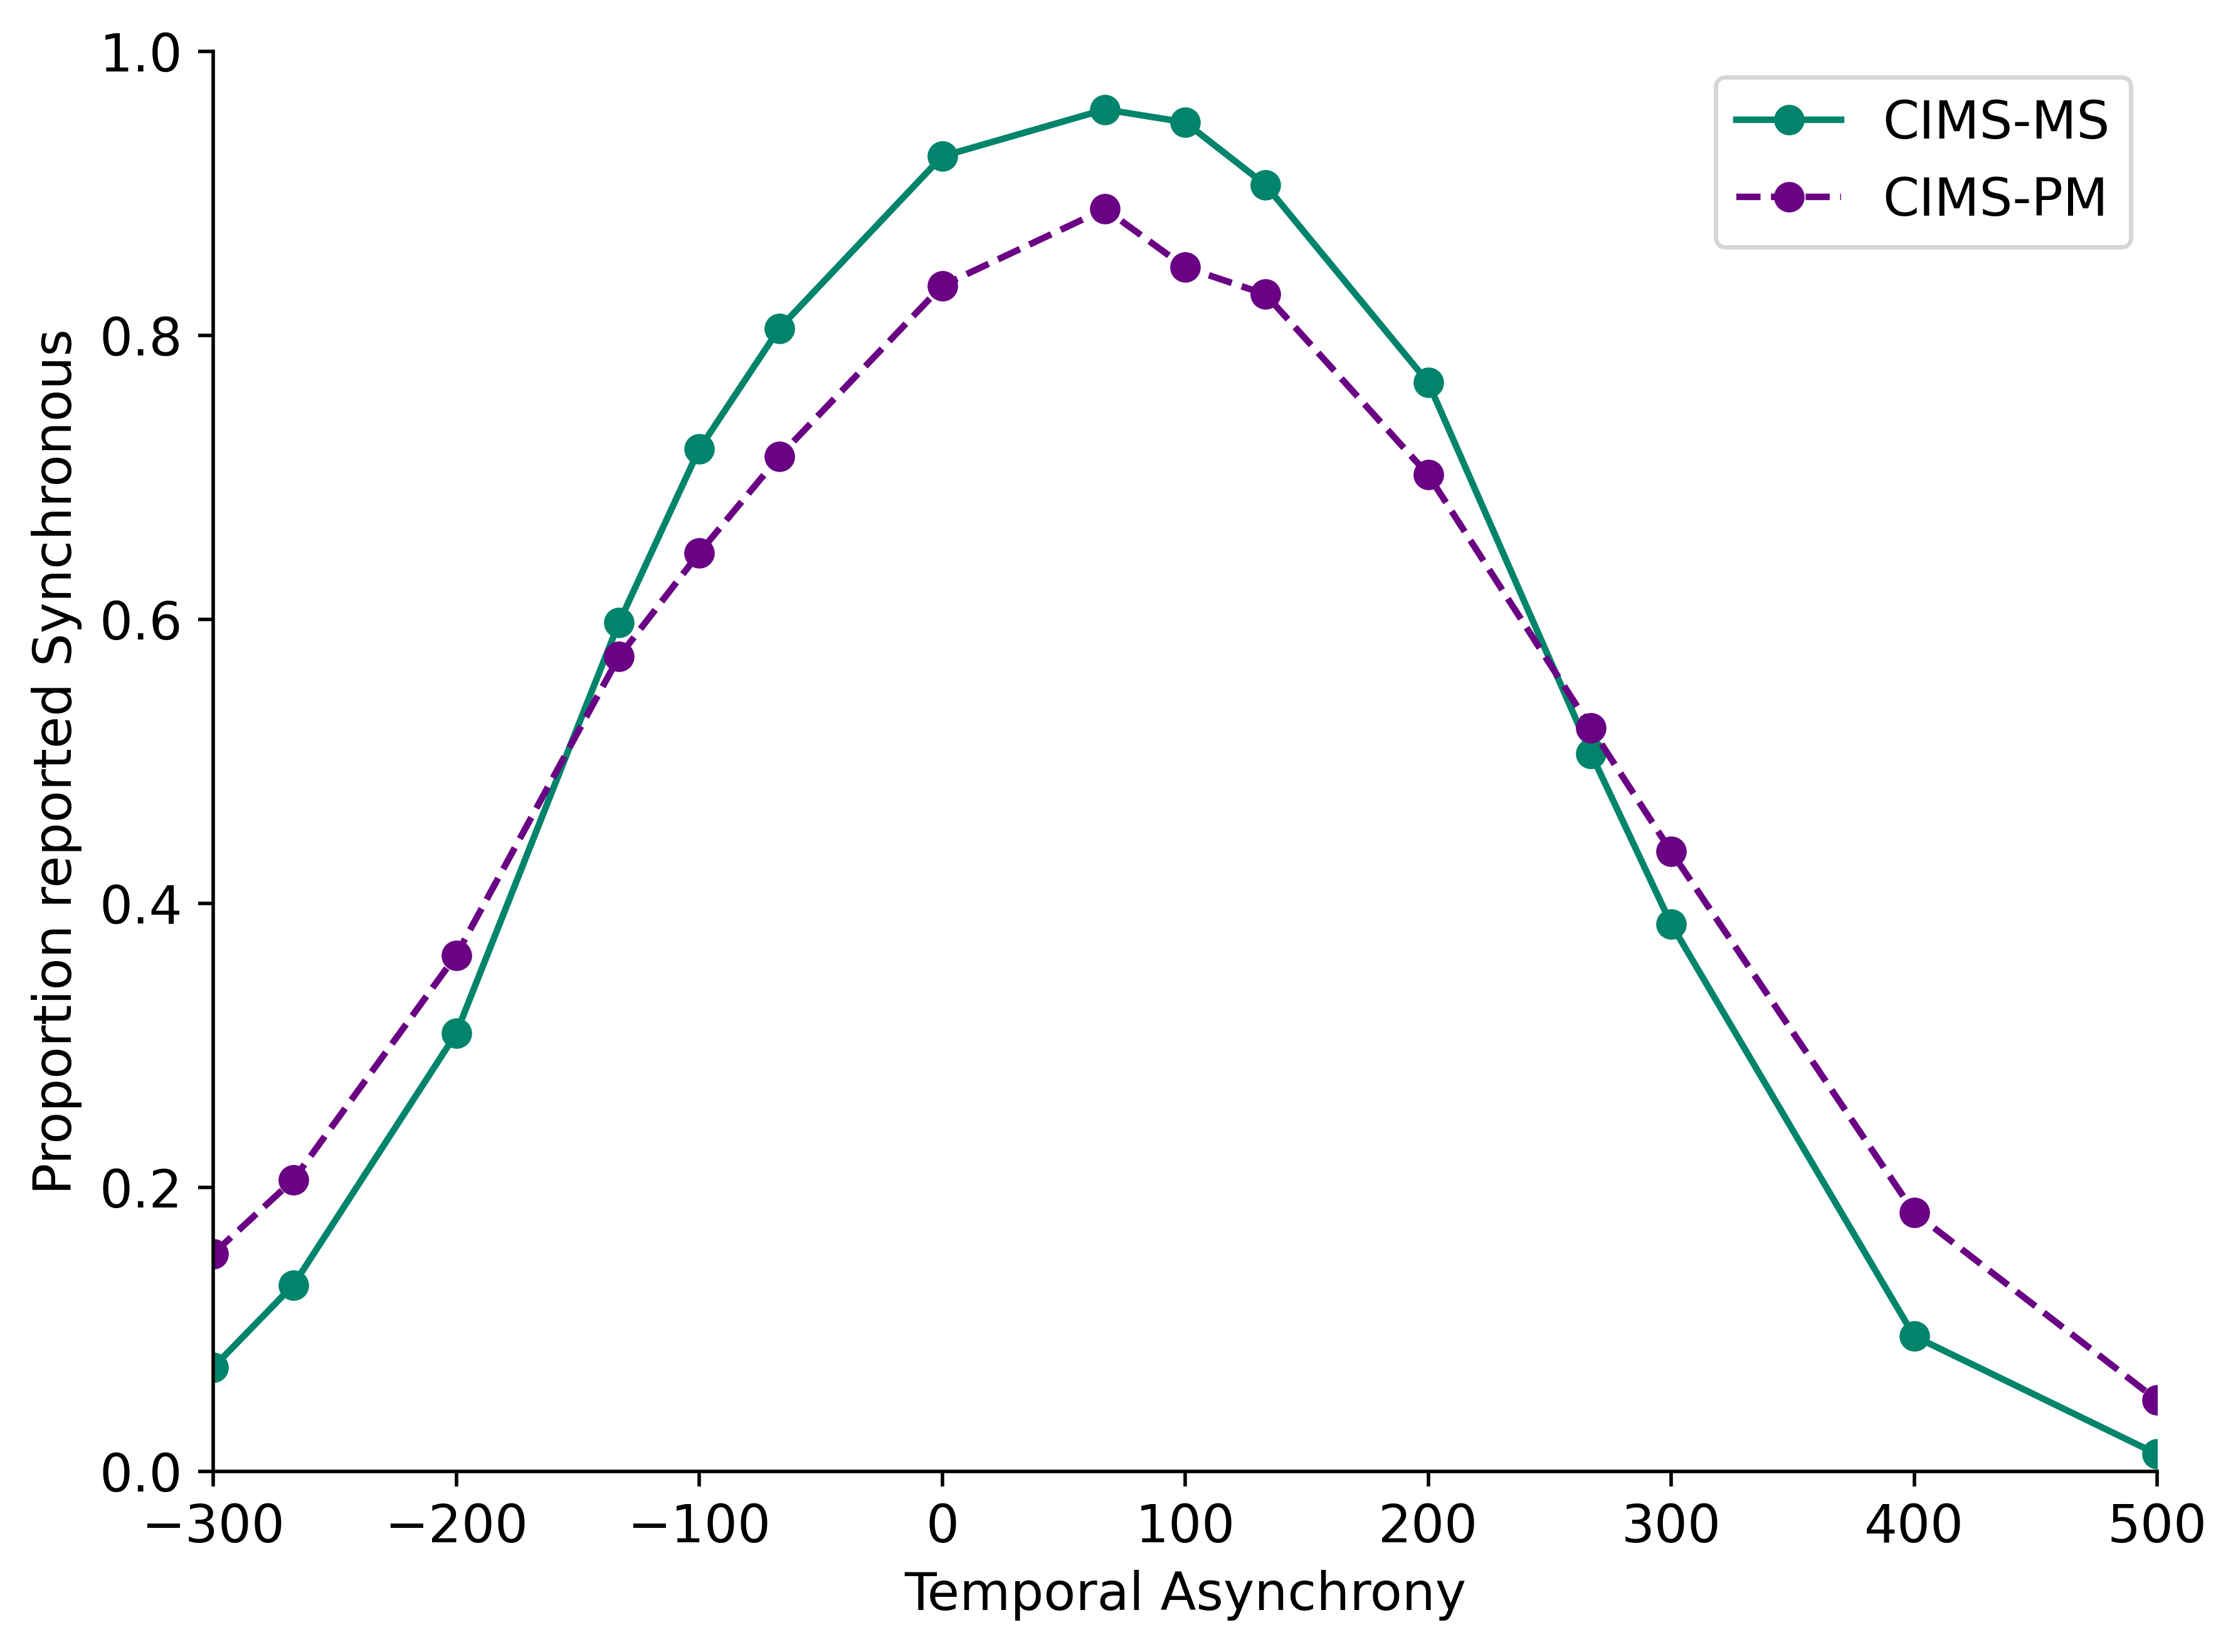

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [181]:
#PLOT

from matplotlib import cm

plt.figure(figsize=(8,6), dpi = 500)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['savefig.format'] = ['svg']
plt.rcParams['image.cmap']='jet'

plt.xlabel("Temporal Asynchrony")
plt.ylabel("Proportion reported Synchronous")
plt.ylim([0,1])
plt.xlim([-300, 500])

x = async_conditions
y1 = MS_props
y2 = PM_props

plt.plot(x, y1, label = "CIMS-MS", marker = 'o', color = '#00846b')
plt.plot(x, y2, label = "CIMS-PM", marker = 'o', color = '#6a0084', linestyle = 'dashed')

plt.legend()
plt.show()
plt.savefig("SIMULATED-RESPONSES.png")
#files.download("SIMULATED-RESPONSES.png") 